In [1]:
# https://pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/

import numpy as np
import random
import os

# ! pip install split-folders
from imutils import paths
import cv2

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.preprocessing import image


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

import matplotlib.pyplot as plt

rs = 42
def reset_random_seeds(rs):
   os.environ['PYTHONHASHSEED']=str(rs)
   tf.random.set_seed(rs)
   np.random.seed(rs)
   random.seed(rs)
reset_random_seeds(rs)

map_dir = 'map 5'

# Part 1 - Data Preprocessing

## Split into train , test data

In [2]:
# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images('./data/humanModel_v1_dataset/')))
random.shuffle(imagePaths)

# initialize the data
data = []
actionLabels = []
rateLabels = []

[INFO] loading images...


### Preprocessing the Training set

In [3]:
batch_size = 64
IMG_SIZE = 10

# loop over the input images
for imagePath in imagePaths:
	# load the image, pre-process it, and store it in the data list
	image = cv2.imread(imagePath)
	# image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
	# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = img_to_array(image)
	data.append(image)
	# extract the action and rate from the path and
	# update the respective lists
	(action, rate) = imagePath.split(os.path.sep)[-2].split("_")
	actionLabels.append(action)
	rateLabels.append(rate)

In [4]:
# scale the raw pixel intensities to the range [0, 1] and convert to
# a NumPy array
data = np.array(data, dtype="float") / 255.0
print("[INFO] data matrix: {} images ({:.2f}MB)".format(
	len(imagePaths), data.nbytes / (1024 * 1000.0)))
# convert the label lists to NumPy arrays prior to binarization
actionLabels = np.array(actionLabels)
rateLabels = np.array(rateLabels)
# binarize both sets of labels
print("[INFO] binarizing labels...")
actionLB = LabelBinarizer()
rateLB = LabelEncoder()
actionLabels = actionLB.fit_transform(actionLabels)
rateLabels = rateLB.fit_transform(rateLabels) / 7

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, actionLabels, rateLabels, test_size=0.2, random_state=42)
(trainX, testX, trainActionY, testActionY, trainRateY, testRateY) = split

[INFO] data matrix: 1056 images (2.48MB)
[INFO] binarizing labels...


## View some data

In [5]:
ACTION_NUM = 5

# Define model layers.
input_layer = Input(shape=(IMG_SIZE,IMG_SIZE,3))
X = Conv2D(8, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)
X = Conv2D(16, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(X)
X = Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(X)
X = MaxPooling2D()(X)
X = Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(X)
X = Dropout(0.5)(X)
X = Flatten()(X)
X = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(X)

# action output will be fed from the first dense
action_output = Dense(ACTION_NUM, activation='softmax', name='action_output')(X)
# rate output will be fed from the second dense
rate_output = Dense(1, activation='linear', name='rate_output')(X)

# Define the model with the input layer 
# and a list of output layers
model = Model(inputs=input_layer,outputs=[action_output, rate_output])

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 10, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 10, 10, 8)    392         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 10, 10, 16)   2064        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 10, 10, 16)   2320        conv2d_1[0][0]                   
______________________________________________________________________________________________

In [7]:
from tensorflow.keras import backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 350
INIT_LR = 1e-3

# define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
losses = {
	"action_output": "categorical_crossentropy",
	"rate_output": rmse,
}
lossWeights = {"action_output": 0.7, "rate_output": 0.3}
# initialize the optimizer and compile the model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
	metrics=["accuracy"])

[INFO] compiling model...


In [8]:
# train the network to perform multi-output classification
history = model.fit(x=trainX,
	y={"action_output": trainActionY, "rate_output": trainRateY},
	validation_data=(testX,
		{"action_output": testActionY, "rate_output": testRateY}),
	epochs=EPOCHS)
# save the model to disk
# print("[INFO] serializing network...")
# model.save(args["model"], save_format="h5")

Epoch 1/350
27/27 [==============================] - 2s 12ms/step - loss: 1.9989 - action_output_loss: 1.5776 - rate_output_loss: 0.3564 - action_output_accuracy: 0.3341 - rate_output_accuracy: 0.2690 - val_loss: 1.7789 - val_action_output_loss: 1.5266 - val_rate_output_loss: 0.2683 - val_action_output_accuracy: 0.3726 - val_rate_output_accuracy: 0.2689
Epoch 2/350
27/27 [==============================] - 0s 3ms/step - loss: 1.6576 - action_output_loss: 1.4922 - rate_output_loss: 0.2908 - action_output_accuracy: 0.3791 - rate_output_accuracy: 0.2559 - val_loss: 1.5399 - val_action_output_loss: 1.4796 - val_rate_output_loss: 0.2643 - val_action_output_accuracy: 0.3726 - val_rate_output_accuracy: 0.2689
Epoch 3/350
27/27 [==============================] - 0s 3ms/step - loss: 1.4690 - action_output_loss: 1.4639 - rate_output_loss: 0.2832 - action_output_accuracy: 0.3791 - rate_output_accuracy: 0.2536 - val_loss: 1.4027 - val_action_output_loss: 1.4686 - val_rate_output_loss: 0.2655 - val_

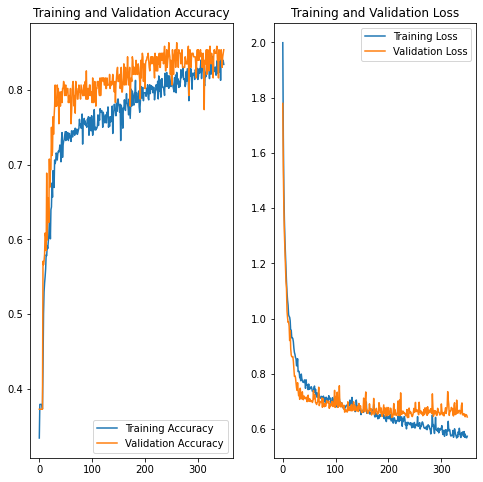

In [9]:
acc = history.history['action_output_accuracy']
val_acc = history.history['val_action_output_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
_ = model.evaluate(x=testX, y={'action_output': testActionY, 'rate_output': testRateY})

7/7 [==============================] - 0s 2ms/step - loss: 0.6432 - action_output_loss: 0.5625 - rate_output_loss: 0.2537 - action_output_accuracy: 0.8538 - rate_output_accuracy: 0.2689


In [11]:
# Save the entire model as a SavedModel.
model.save('./data/'+map_dir+'/humanModel_v1.h5')

In [12]:
# new_model = tf.keras.models.load_model('./data/humanModel/mode_v0')

# # Check its architecture
# new_model.summary()

### Predict on new data

In [13]:
path = "./data/humanModel_v1_dataset/32_1/-Ms8axULhIjj8UI3-s6g_25.png"

img = keras.preprocessing.image.load_img(
    path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array = img_array/255
predictions = model.predict(img_array)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(np.argmax(predictions[0]), 100 * np.max(predictions[0]))
)
print(
    "This image with rate of {}".format(predictions[1] * 7)
)

This image most likely belongs to 3 with a 63.19 percent confidence.
This image with rate of [[3.401655]]
